In [1]:
# Goal: Predict the win rate of a team/combination of agents given minimal data
# such as statistics for the first few rounds (or just the team composition)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

engine = create_engine("sqlite:///data/valorant.sqlite")

scoreboard = pd.read_sql_table("Game_Scoreboard", con=engine)
rounds = pd.read_sql_table("Game_Rounds", con=engine)
games = pd.read_sql_table("Games", con=engine)

engine.dispose()

In [2]:
print("Scoreboard:")
print(scoreboard.head())
print("Rounds:")
print(rounds.head())
print("Games:")
print(games.head())

Scoreboard:
  GameID PlayerID PlayerName TeamAbbreviation    Agent    ACS  Kills  Deaths  \
0  60894     8419     Reduxx             Boos     jett  313.0   24.0    10.0   
1  60894      466     ChurmZ             Boos  chamber  227.0   16.0    10.0   
2  60894     3712   diaamond             Boos     sova  226.0   17.0     9.0   
3  60894     5099     Boltzy             Boos    viper  218.0   17.0    12.0   
4  60894     3983     Virtyy             Boos     skye   80.0    5.0    13.0   

   Assists  PlusMinus  ...  Num_4Ks  Num_5Ks  OnevOne  OnevTwo  OnevThree  \
0      3.0       14.0  ...      2.0      0.0      1.0      0.0        0.0   
1      7.0        6.0  ...      0.0      0.0      0.0      0.0        0.0   
2      8.0        8.0  ...      0.0      0.0      1.0      0.0        0.0   
3      2.0        5.0  ...      0.0      0.0      1.0      0.0        0.0   
4      3.0       -8.0  ...      0.0      0.0      0.0      0.0        0.0   

   OnevFour  OnevFive  Econ  Plants  Defuses

__Making a prediction based on just the team composition and map:__

In [3]:
# Desired DataFrame structure:
# Index: GameID, Columns: Team1, Team1 agents, Team2, Team2 agents, Map, Winner

print(len(scoreboard))
#scoreboard_grouped = scoreboard.copy().groupby('GameID')
game_ids_s = scoreboard['GameID'].unique()
print(len(game_ids_s))
#print(len(scoreboard_grouped))
print("------")
print(len(rounds))
print("------")

# Filter by common GameIDs
games = games[games['GameID'].isin(game_ids_s)]

game_ids_g = games['GameID'].unique()
scoreboard = scoreboard[scoreboard['GameID'].isin(game_ids_g)]

print(len(scoreboard))
print(len(games))
#print(scoreboard.head())

157939
15878
------
15531
------
157939
15878


In [4]:
# Group agents by GameID and TeamAbbreviation into sets
team_compositions = pd.pivot_table(
    scoreboard,
    values='Agent',  # The column containing the agents
    index=['GameID', 'TeamAbbreviation'],  # Rows will be grouped by GameID and TeamID
    aggfunc=lambda x: set(x)  # Combine agent names into a set for each team
)

# Step 1: Filter GameIDs with exactly two teams
team_counts = team_compositions.groupby(level='GameID').size()
valid_game_ids = team_counts[team_counts == 2].index
team_compositions = team_compositions.loc[valid_game_ids]

# Step 2: Assign positions in each group by GameID
merged = team_compositions.merge(games, how="left", on="GameID")
merged["RowPosition"] = merged.groupby("GameID").cumcount()

# Step 3: Update TeamAbbreviation based on RowPosition
merged.loc[merged["RowPosition"] == 0, "TeamAbbreviation"] = merged["Team1"]
merged.loc[merged["RowPosition"] == 1, "TeamAbbreviation"] = merged["Team2"]

# Add column for winner
merged["Winner1"] = merged["TeamAbbreviation"] == merged["Winner"]

# Drop unnecessary columns like Team1, Team2, and RowPosition
team_compositions = merged[["GameID", "TeamAbbreviation", "Agent", "Winner1"]]


print(team_compositions.head(10))
# print(teams[teams['GameID'] == '10004'])
print(len(team_compositions.index.get_level_values(0).unique()) / 2)
# print(len(teams['GameID']))

  GameID   TeamAbbreviation                                  Agent  Winner1
0  10003       Bren Esports    {cypher, phoenix, sova, omen, raze}    False
1  10003  Attack All Around      {cypher, reyna, sova, omen, raze}     True
2  10004       Bren Esports      {cypher, reyna, jett, sova, omen}     True
3  10004  Attack All Around     {reyna, jett, sova, omen, killjoy}    False
4  10005       Bren Esports     {cypher, jett, omen, raze, breach}    False
5  10005  Attack All Around    {jett, omen, killjoy, raze, breach}     True
6  10006             HSDIRR     {sage, viper, phoenix, omen, raze}     True
7  10006           MJAOMODE  {viper, phoenix, omen, killjoy, raze}    False
8  10007             HSDIRR     {sage, viper, phoenix, jett, omen}    False
9  10007           MJAOMODE  {viper, phoenix, omen, killjoy, raze}     True
14771.0


In [5]:
# Testing win rate for a specific team comp
selection = {'phoenix', 'omen', 'cypher', 'sage', 'raze'}
g = team_compositions[team_compositions['Agent'] == selection]
print(len(g))
s = g['Winner1'].sum()
print(s)
print("This comp's win rate is: %" + str((s/len(g)) * 100))

28
19
This comp's win rate is: %67.85714285714286


One-Hot Encoding Agents

In [6]:
# Get all unique agents
all_agents_set = set().union(*merged["Agent"])
all_agents_set.remove('')

# Sort agents so they are not in a random order every time
all_agents = sorted(list(all_agents_set))

# One-hot encode agents
def encode_agents(row_agents, all_agents):
    return {agent: 1 if agent in row_agents else 0 for agent in all_agents}

# Create a DataFrame where columns represent agents
agent_columns = merged["Agent"].apply(lambda x: encode_agents(x, all_agents))

# Expand the one-hot encoding into separate columns
agent_df = pd.DataFrame(agent_columns.tolist(), index=merged.index)

# Combine with base DataFrame
merged = pd.concat([merged, agent_df], axis=1).drop(columns=["Agent"])  # Agents no longer needed

# Some cleaning
merged_orig = merged.copy()
merged_clean = merged.drop(columns=['MatchID', 'Team1ID', 'Team2ID', 'Team1_TotalRounds',
                                    'Team2_TotalRounds', 'Team1_SideFirstHalf', 'Team2_SideFirstHalf',
                                    'Team1_RoundsFirstHalf', 'Team1_RoundsSecondtHalf', 'Team1_RoundsOT',
                                    'Team2_RoundsFirstHalf', 'Team2_RoundsSecondtHalf', 'Team2_RoundsOT',
                                    'Team1_PistolWon', 'Team1_Eco', 'Team1_EcoWon', 'Team1_SemiEco',
                                    'Team1_SemiEcoWon', 'Team1_SemiBuy', 'Team1_SemiBuyWon',
                                    'Team1_FullBuy', 'Team1_FullBuyWon', 'Team2_PistolWon', 'Team2_Eco',
                                    'Team2_EcoWon', 'Team2_SemiEco', 'Team2_SemiEcoWon', 'Team2_SemiBuy',
                                    'Team2_SemiBuyWon', 'Team2_FullBuy', 'Team2_FullBuyWon'])

merged_clean.head()

,GameID,Map,Team1,Team2,Winner,RowPosition,TeamAbbreviation,Winner1,astra,breach,...,killjoy,omen,phoenix,raze,reyna,sage,skye,sova,viper,yoru
0,10003,Bind,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,0,0,...,0,1,1,1,0,0,0,1,0,0
1,10003,Bind,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,0,0,...,0,1,0,1,1,0,0,1,0,0
2,10004,Haven,Bren Esports,Attack All Around,Bren Esports,0,Bren Esports,True,0,0,...,0,1,0,0,1,0,0,1,0,0
3,10004,Haven,Bren Esports,Attack All Around,Bren Esports,1,Attack All Around,False,0,0,...,1,1,0,0,1,0,0,1,0,0
4,10005,Split,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,0,1,...,0,1,0,1,0,0,0,0,0,0


Combining rows for both teams into one row

In [7]:
merged_clean['Map'] = merged_clean['Map'].astype('category')

# Split data into Team1 and Team2
team1 = merged_clean[merged_clean['Winner1'] == True]
team2 = merged_clean[merged_clean['Winner1'] == False]

# Rename columns to distinguish between Team1 and Team2
team1 = team1.add_prefix("team1_")
team2 = team2.add_prefix("team2_")

# Combine both teams into a single row
final_df = pd.merge(team1, team2, left_on="team1_GameID", right_on="team2_GameID")

# Drop redundant columns
columns_to_drop = [
    'team1_Team1', 'team1_Team2', 'team2_Team1', 'team2_Map',
    'team2_Team2', 'team1_RowPosition', 'team2_RowPosition',
    'team1_Winner', 'team2_Winner', 'team2_GameID'
]

final_df = final_df.rename(columns={'team1_GameID': 'GameID', 'team1_TeamAbbreviation': 'Team1',
                                    'team2_TeamAbbreviation': 'Team2', 'team1_Map': 'Map',})

# One-hot encode the 'Map' column
map_dummies = pd.get_dummies(final_df['Map'], prefix='Map')

# Add the one-hot encoded columns to the DataFrame
final_df = pd.concat([final_df, map_dummies], axis=1)

# Drop the original 'Map' column as it's no longer needed, along with other columns
final_df = final_df.drop(columns=['Map'])

final_df = final_df.drop(columns=columns_to_drop)

# Re-position Winner1 column at end of columns
final_df['Winner1'] = final_df['team1_Winner1'] == True
final_df = final_df.drop(columns=['team1_Winner1', 'team2_Winner1'])

final_df.head()

,GameID,Team1,team1_astra,team1_breach,team1_brimstone,team1_chamber,team1_cypher,team1_jett,team1_kayo,team1_killjoy,...,team2_yoru,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
0,10003,Attack All Around,0,0,0,0,1,0,0,0,...,0,False,True,False,False,False,False,False,False,True
1,10004,Bren Esports,0,0,0,0,1,1,0,0,...,0,False,False,False,False,True,False,False,False,True
2,10005,Attack All Around,0,1,0,0,0,1,0,1,...,0,False,False,False,False,False,False,True,False,True
3,10006,HSDIRR,0,0,0,0,0,0,0,0,...,0,True,False,False,False,False,False,False,False,True
4,10007,MJAOMODE,0,0,0,0,0,0,0,1,...,0,False,False,False,False,True,False,False,False,True


In [8]:
final_df.iloc[:, 1:19].head()

,Team1,team1_astra,team1_breach,team1_brimstone,team1_chamber,team1_cypher,team1_jett,team1_kayo,team1_killjoy,team1_omen,team1_phoenix,team1_raze,team1_reyna,team1_sage,team1_skye,team1_sova,team1_viper,team1_yoru
0,Attack All Around,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0
1,Bren Esports,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0
2,Attack All Around,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0
3,HSDIRR,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0
4,MJAOMODE,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0


At this point, the winning team is always on the left, which must be fixed to prevent bias

In [9]:
# Randomly decide whether to swap Team1 and Team2 for each row
swap_teams = np.random.rand(len(final_df)) > 0.5

# for idx in final_df.index[swap_teams]:
#     # Swap columns for Team1 and Team2
#     temp_team_columns = final_df.loc[idx, 'Team1':'team1_breach'].copy()
#     final_df.loc[idx, 'Team1':'team1_breach'] = final_df.loc[idx, 'Team2':'team2_breach'].values
#     final_df.loc[idx, 'Team2':'team2_breach'] = temp_team_columns.values
#
#     # Flip the Winner1 column (because winner changes sides)
#     final_df.loc[idx, 'Winner1'] = not final_df.loc[idx, 'Winner1']

# Vectorized:
# team1_columns = final_df.loc[:, 'Team1':'team1_breach'].columns.tolist()
# team2_columns = final_df.loc[:, 'Team2':'team2_breach'].columns.tolist() # order of agents changed, so breach was no longer last
team1_columns = final_df.iloc[:, 1:19].columns.tolist()
team2_columns = final_df.iloc[:, 19:37].columns.tolist()

# Swap columns where swap_teams is True
temp_team1 = final_df.loc[swap_teams, team1_columns].copy()

final_df.loc[swap_teams, team1_columns] = final_df.loc[swap_teams, team2_columns].values
final_df.loc[swap_teams, team2_columns] = temp_team1.values  # Use the temporary data here

# Flip Winner1 column for swapped rows
final_df.loc[swap_teams, 'Winner1'] = ~final_df.loc[swap_teams, 'Winner1']

duplicates = final_df[final_df['Team1'] == final_df['Team2']]
print(f"Number of duplicate rows: {len(duplicates)}")
# ^ There should be 0 duplicates

final_df.head()

Number of duplicate rows: 0


,GameID,Team1,team1_astra,team1_breach,team1_brimstone,team1_chamber,team1_cypher,team1_jett,team1_kayo,team1_killjoy,...,team2_yoru,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
0,10003,Attack All Around,0,0,0,0,1,0,0,0,...,0,False,True,False,False,False,False,False,False,True
1,10004,Attack All Around,0,0,0,0,0,1,0,1,...,0,False,False,False,False,True,False,False,False,False
2,10005,Bren Esports,0,1,0,0,1,1,0,0,...,0,False,False,False,False,False,False,True,False,False
3,10006,MJAOMODE,0,0,0,0,0,0,0,1,...,0,True,False,False,False,False,False,False,False,False
4,10007,MJAOMODE,0,0,0,0,0,0,0,1,...,0,False,False,False,False,True,False,False,False,True


In [10]:
# Check Winner1 distribution
team1_wins = final_df['Winner1'].sum()
total_matches = len(final_df)
print(f"Team1 Wins: {team1_wins}")
print(f"Team2 Wins: {total_matches - team1_wins}")

Team1 Wins: 7425
Team2 Wins: 7346


Now the distribution of winners among Team1 and Team2 is roughly equal, which should prevent bias

In [11]:
from sklearn.model_selection import train_test_split

X = final_df.drop(columns=['Team1', 'Team2', 'Winner1', 'GameID'])
y = final_df['Winner1']

# 80-20 training/testing split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X1, X2, y1, y2 = train_test_split(X, y, random_state=41,
                                  train_size=0.5)
# print(f"Training Data: {X_train.shape}, Test Data: {X_test.shape}")
print(f"Training Data: {X1.shape}, {X2.shape}")

Training Data: (7385, 42), (7386, 42)


Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.50      0.47      0.49      3680
        True       0.51      0.54      0.52      3705

    accuracy                           0.51      7385
   macro avg       0.51      0.51      0.50      7385
weighted avg       0.51      0.51      0.50      7385

[[1723 1957]
 [1694 2011]]
              precision    recall  f1-score   support

       False       0.50      0.49      0.50      3666
        True       0.51      0.52      0.51      3720

    accuracy                           0.50      7386
   macro avg       0.50      0.50      0.50      7386
weighted avg       0.50      0.50      0.50      7386

[[1797 1869]
 [1792 1928]]
Random Forest Accuracy: 0.5056194989844279 0.5043325209856485
Mean: 0.5049760099850382


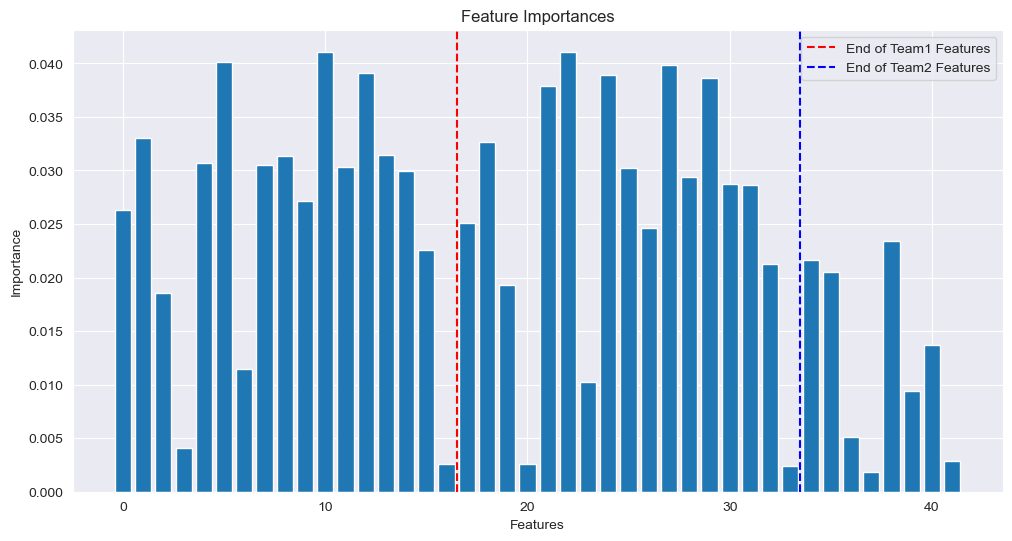

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=20,
#                                   min_samples_leaf=4, random_state=42)
rf_model = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=5,
                                  min_samples_leaf=2)
# (n_estimators=300, max_depth=30, min_samples_split=80,
#                                   min_samples_leaf=180)
#rf_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,min_samples_split=5, min_samples_leaf=2)


# Train model
# rf_model.fit(X_train, y_train)

# Train and test with cross-validation
y2_model = rf_model.fit(X1, y1).predict(X2)
y1_model = rf_model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

# Test model
# y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
#print(classification_report(y_test, y_pred_rf))
#print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y1, y1_model))
print(confusion_matrix(y1, y1_model))
print(classification_report(y2, y2_model))
print(confusion_matrix(y2, y2_model))
print("Random Forest Accuracy:", accuracy_score(y1, y1_model), accuracy_score(y2, y2_model))
print("Mean:", (float(accuracy_score(y1, y1_model)) + float(accuracy_score(y2, y2_model))) / 2)
importances = rf_model.feature_importances_
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances)

# Add group labels
# plt.xticks(range(len(importances)),
#            ['Team1'] * 18 + ['Team2'] * 18 + ['Map'] * len(importances[36:]), rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')

# Annotate sections
plt.axvline(x=16.5, color='red', linestyle='--', label='End of Team1 Features')
plt.axvline(x=33.5, color='blue', linestyle='--', label='End of Team2 Features')

# Add legend
plt.legend()
plt.title("Feature Importances")
plt.show()

In [49]:
print(X.columns[27:30])

Index(['team2_raze', 'team2_reyna', 'team2_sage'], dtype='object')


Predicting a single match outcome

In [14]:
team1_agents = {"brimstone", "phoenix", "cypher", "jett", "sage"}
team2_agents = {"killjoy", "omen", "sova", "jett", "raze"}
map_to_predict = "Ascent"  # Replace with the selected map for prediction

# One-hot encode agents for both teams and map
team1_encoded = {f'team1_{agent}': 1 if agent in team1_agents else 0 for agent in all_agents}
team2_encoded = {f'team2_{agent}': 1 if agent in team2_agents else 0 for agent in all_agents}
all_maps = map_dummies.columns.tolist()
map_encoded = {f"{map}": (1 if map == "Map_" + map_to_predict else 0) for map in all_maps}

# Combine into a single row
input_row = pd.DataFrame([{**team1_encoded, **team2_encoded, **map_encoded}])

# Predict using the model
rf_probability = rf_model.predict_proba(input_row)[0][1] * 100  # Probability Team1 wins
rf_probability_team2 = 100 - rf_probability  # Probability Team2 wins

print("Agents:", all_agents)
print("Maps:", all_maps)
print(f"Chance of Team1 winning: {rf_probability:.2f}%")
print(f"Chance of Team2 winning: {rf_probability_team2:.2f}%")

Agents: ['astra', 'breach', 'brimstone', 'chamber', 'cypher', 'jett', 'kayo', 'killjoy', 'omen', 'phoenix', 'raze', 'reyna', 'sage', 'skye', 'sova', 'viper', 'yoru']
Maps: ['Map_Ascent', 'Map_Bind', 'Map_Breeze', 'Map_Fracture', 'Map_Haven', 'Map_Icebox', 'Map_Split', 'Map_TBD']
Chance of Team1 winning: 43.94%
Chance of Team2 winning: 56.06%


Skipping the Grid Search is highly recommended, but runGridSearch can be set to True if you want to run it.

In [ ]:
runGridSearch = False

In [45]:
if runGridSearch:
    from sklearn.model_selection import GridSearchCV

    # Define the hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],  # Vary the number of trees
        'max_depth': [5, 10, 15],  # Vary tree depth
        'min_samples_split': [2, 5, 10],  # Vary splitting criteria
        'min_samples_leaf': [1, 2, 4]  # Vary minimum samples per leaf
    }

    # Create Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # Perform Grid Search
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
    #grid_search.fit(X_train, y_train)
    grid_search.fit(X2, y2)

    # Output the best parameters and accuracy
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)
    # Note: best was {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 200}
    # Best Accuracy: 0.5129488668677783

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.7s


KeyboardInterrupt: 

__Accuracy based on just team composition and map is low, so I will try to increase accuracy by adding the round scores based on the winner of each round in a game.__

In [15]:
game_ids = final_df['GameID']
rounds_filtered = rounds[rounds['GameID'].isin(game_ids)]
print(len(rounds_filtered))
print(len(rounds))
print(len(game_ids))

# Number of games in rounds_filtered is less than in final_df,
# so another round of filtering is needed

game_ids = rounds_filtered['GameID']
final_df2 = final_df[final_df['GameID'].isin(game_ids)]
print("-----")
print(len(final_df2))
rounds_filtered.head()

14393
15531
14771
-----
14393


,GameID,Team1ID,Team2ID,RoundHistory
0,60894,6903,6020,"{1: {'RoundWinner': 'BOOS', 'ScoreAfterRound':..."
1,60895,6903,6020,"{1: {'RoundWinner': 'PHO ', 'ScoreAfterRound':..."
2,60896,6903,6020,"{1: {'RoundWinner': 'PHO ', 'ScoreAfterRound':..."
5,60888,6461,6903,"{1: {'RoundWinner': 'BOOS', 'ScoreAfterRound':..."
6,60889,6461,6903,"{1: {'RoundWinner': 'BOOS', 'ScoreAfterRound':..."


In [16]:
merged_orig.head(10)

,GameID,MatchID,Map,Team1ID,Team2ID,Team1,Team2,Winner,Team1_TotalRounds,Team2_TotalRounds,...,killjoy,omen,phoenix,raze,reyna,sage,skye,sova,viper,yoru
0,10003,6031,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,13,15,...,0,1,1,1,0,0,0,1,0,0
1,10003,6031,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,13,15,...,0,1,0,1,1,0,0,1,0,0
2,10004,6031,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,13,11,...,0,1,0,0,1,0,0,1,0,0
3,10004,6031,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,13,11,...,1,1,0,0,1,0,0,1,0,0
4,10005,6031,Split,694,497,Bren Esports,Attack All Around,Attack All Around,0,13,...,0,1,0,1,0,0,0,0,0,0
5,10005,6031,Split,694,497,Bren Esports,Attack All Around,Attack All Around,0,13,...,1,1,0,1,0,0,0,0,0,0
6,10006,6034,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,13,9,...,0,1,1,1,0,1,0,0,1,0
7,10006,6034,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,13,9,...,1,1,1,1,0,0,0,0,1,0
8,10007,6034,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,11,13,...,0,1,1,0,0,1,0,0,1,0
9,10007,6034,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,11,13,...,1,1,1,1,0,0,0,0,1,0


In [17]:
merged_orig = merged_orig.drop(columns=['MatchID', 'Team1_TotalRounds',
                                    'Team2_TotalRounds', 'Team1_SideFirstHalf', 'Team2_SideFirstHalf',
                                    'Team1_RoundsFirstHalf', 'Team1_RoundsSecondtHalf', 'Team1_RoundsOT',
                                    'Team2_RoundsFirstHalf', 'Team2_RoundsSecondtHalf', 'Team2_RoundsOT',
                                    'Team1_PistolWon', 'Team1_Eco', 'Team1_EcoWon', 'Team1_SemiEco',
                                    'Team1_SemiEcoWon', 'Team1_SemiBuy', 'Team1_SemiBuyWon',
                                    'Team1_FullBuy', 'Team1_FullBuyWon', 'Team2_PistolWon', 'Team2_Eco',
                                    'Team2_EcoWon', 'Team2_SemiEco', 'Team2_SemiEcoWon', 'Team2_SemiBuy',
                                    'Team2_SemiBuyWon', 'Team2_FullBuy', 'Team2_FullBuyWon'])
merged_orig.head()

,GameID,Map,Team1ID,Team2ID,Team1,Team2,Winner,RowPosition,TeamAbbreviation,Winner1,...,killjoy,omen,phoenix,raze,reyna,sage,skye,sova,viper,yoru
0,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,1,1,0,0,0,1,0,0
1,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,...,0,1,0,1,1,0,0,1,0,0
2,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,0,Bren Esports,True,...,0,1,0,0,1,0,0,1,0,0
3,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,1,Attack All Around,False,...,1,1,0,0,1,0,0,1,0,0
4,10005,Split,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,0,1,0,0,0,0,0,0


In [18]:
merged_orig.head(10)

,GameID,Map,Team1ID,Team2ID,Team1,Team2,Winner,RowPosition,TeamAbbreviation,Winner1,...,killjoy,omen,phoenix,raze,reyna,sage,skye,sova,viper,yoru
0,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,1,1,0,0,0,1,0,0
1,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,...,0,1,0,1,1,0,0,1,0,0
2,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,0,Bren Esports,True,...,0,1,0,0,1,0,0,1,0,0
3,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,1,Attack All Around,False,...,1,1,0,0,1,0,0,1,0,0
4,10005,Split,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,0,1,0,0,0,0,0,0
5,10005,Split,694,497,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,...,1,1,0,1,0,0,0,0,0,0
6,10006,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,0,HSDIRR,True,...,0,1,1,1,0,1,0,0,1,0
7,10006,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,1,MJAOMODE,False,...,1,1,1,1,0,0,0,0,1,0
8,10007,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,0,HSDIRR,False,...,0,1,1,0,0,1,0,0,1,0
9,10007,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,1,MJAOMODE,True,...,1,1,1,1,0,0,0,0,1,0


In [19]:
import ast
import json

# Parse Round Histories Function
def parse_round_histories(rounds_df):
    """Vectorized parsing of all round histories"""
    parsed_histories = {}

    for idx, row in rounds_df.iterrows():
        game_id = row['GameID']
        try:
            # Try different parsing methods
            try:
                history = ast.literal_eval(row['RoundHistory'])
            except (SyntaxError, ValueError):
                history = json.loads(row['RoundHistory'])

            parsed_histories[game_id] = history
        except:
            # Skip problematic entries
            continue

    return parsed_histories


# Parse all round histories once
parsed_round_histories = parse_round_histories(rounds_filtered)

In [20]:
parsed_round_histories['10003']

{1: {'RoundWinner': 'BRN',
  'ScoreAfterRound': '1-0',
  'WinType': 'defuse',
  'Team1Bank': 0.0,
  'Team2Bank': 100.0,
  'Team1BuyType': 'eco',
  'Team2BuyType': 'eco'},
 2: {'RoundWinner': 'BRN',
  'ScoreAfterRound': '2-0',
  'WinType': 'elim',
  'Team1Bank': 5200.0,
  'Team2Bank': 10000.0,
  'Team1BuyType': 'semi-buy',
  'Team2BuyType': 'eco'},
 3: {'RoundWinner': 'AAA',
  'ScoreAfterRound': '2-1',
  'WinType': 'boom',
  'Team1Bank': 11000.0,
  'Team2Bank': 1200.0,
  'Team1BuyType': 'full-buy',
  'Team2BuyType': 'full-buy'},
 4: {'RoundWinner': 'AAA',
  'ScoreAfterRound': '2-2',
  'WinType': 'boom',
  'Team1Bank': 4900.0,
  'Team2Bank': 9400.0,
  'Team1BuyType': 'full-buy',
  'Team2BuyType': 'full-buy'},
 5: {'RoundWinner': 'BRN',
  'ScoreAfterRound': '3-2',
  'WinType': 'defuse',
  'Team1Bank': 4700.0,
  'Team2Bank': 16600.0,
  'Team1BuyType': 'semi-buy',
  'Team2BuyType': 'full-buy'},
 6: {'RoundWinner': 'BRN',
  'ScoreAfterRound': '4-2',
  'WinType': 'defuse',
  'Team1Bank': 1050

In [21]:
rounds_hist_list = []

# Adding the round scores to the data
for game_id, rounds in parsed_round_histories.items():
    for round_number, round_info in rounds.items():
        rounds_hist_list.append({'GameID': game_id, 'RoundNumber': round_number, **round_info})

rounds_hist_df = pd.DataFrame(rounds_hist_list)
print(rounds_hist_df.shape, rounds_filtered.shape)
rounds_hist_df.head(25)

(284113, 9) (14393, 4)


,GameID,RoundNumber,RoundWinner,ScoreAfterRound,WinType,Team1Bank,Team2Bank,Team1BuyType,Team2BuyType
0,60894,1,BOOS,1-0,elim,300.0,100.0,eco,eco
1,60894,2,BOOS,2-0,elim,2700.0,8600.0,semi-buy,eco
2,60894,3,BOOS,3-0,elim,12300.0,400.0,semi-buy,full-buy
3,60894,4,BOOS,4-0,elim,23600.0,9800.0,full-buy,semi-eco
4,60894,5,PHO,4-1,boom,24200.0,3300.0,full-buy,full-buy
5,60894,6,PHO,4-2,boom,10200.0,10300.0,full-buy,full-buy
6,60894,7,BOOS,5-2,elim,5700.0,8900.0,full-buy,full-buy
7,60894,8,BOOS,6-2,time,6400.0,2400.0,full-buy,semi-buy
8,60894,9,BOOS,7-2,elim,10900.0,5900.0,full-buy,semi-buy
9,60894,10,PHO,7-3,boom,16500.0,1200.0,full-buy,full-buy


In [22]:
rounds_hist_df = rounds_hist_df.drop(columns=['RoundWinner', 'WinType', 'Team1Bank', 'Team2Bank',
                             'Team1BuyType', 'Team2BuyType'])
# Using str.split() to split at the hyphen and create a Series of lists
split_scores = rounds_hist_df['ScoreAfterRound'].str.split('-', expand=True)

# Create the new columns
rounds_hist_df['Team1_RoundScore'] = pd.to_numeric(split_scores[0], errors='coerce')
rounds_hist_df['Team2_RoundScore'] = pd.to_numeric(split_scores[1], errors='coerce')

# Handle potential errors (non-numeric values, missing values)
# Fill NaN values with appropriate defaults if needed
rounds_hist_df['Team1_RoundScore'] = rounds_hist_df['Team1_RoundScore'].fillna(0)
rounds_hist_df['Team2_RoundScore'] = rounds_hist_df['Team2_RoundScore'].fillna(0)

# Ensure scores are integers
rounds_hist_df['Team1_RoundScore'] = rounds_hist_df['Team1_RoundScore'].astype(int)
rounds_hist_df['Team2_RoundScore'] = rounds_hist_df['Team2_RoundScore'].astype(int)

# Optionally remove the original column if no longer needed
# rounds_hist_df.drop('ScoreAfterRound', axis=1, inplace=True)

# Display a few rows to verify the transformation
rounds_hist_df.head()

,GameID,RoundNumber,ScoreAfterRound,Team1_RoundScore,Team2_RoundScore
0,60894,1,1-0,1,0
1,60894,2,2-0,2,0
2,60894,3,3-0,3,0
3,60894,4,4-0,4,0
4,60894,5,4-1,4,1


In [23]:
merged_orig = merged_orig[merged_orig['GameID'].isin(game_ids)]
print(merged_orig.shape)
print(len(merged_orig) / 2)
merged_orig.head(10)

(28786, 27)
14393.0


,GameID,Map,Team1ID,Team2ID,Team1,Team2,Winner,RowPosition,TeamAbbreviation,Winner1,...,killjoy,omen,phoenix,raze,reyna,sage,skye,sova,viper,yoru
0,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,1,1,0,0,0,1,0,0
1,10003,Bind,694,497,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,...,0,1,0,1,1,0,0,1,0,0
2,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,0,Bren Esports,True,...,0,1,0,0,1,0,0,1,0,0
3,10004,Haven,694,497,Bren Esports,Attack All Around,Bren Esports,1,Attack All Around,False,...,1,1,0,0,1,0,0,1,0,0
4,10005,Split,694,497,Bren Esports,Attack All Around,Attack All Around,0,Bren Esports,False,...,0,1,0,1,0,0,0,0,0,0
5,10005,Split,694,497,Bren Esports,Attack All Around,Attack All Around,1,Attack All Around,True,...,1,1,0,1,0,0,0,0,0,0
6,10006,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,0,HSDIRR,True,...,0,1,1,1,0,1,0,0,1,0
7,10006,Ascent,685,1190,HSDIRR,MJAOMODE,HSDIRR,1,MJAOMODE,False,...,1,1,1,1,0,0,0,0,1,0
8,10007,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,0,HSDIRR,False,...,0,1,1,0,0,1,0,0,1,0
9,10007,Haven,685,1190,HSDIRR,MJAOMODE,MJAOMODE,1,MJAOMODE,True,...,1,1,1,1,0,0,0,0,1,0


In [24]:
merged_orig['Map'] = merged_orig['Map'].astype('category')

# Encode Team ID into names
# merged_orig['Team1'] = str(str(merged_orig['Team1']) + '-' + str(merged_orig['Team1ID']))
# merged_orig['Team2'] = str(str(merged_orig['Team2']) + '-' + str(merged_orig['Team2ID']))

# Split data into Team1 and Team2
odds = merged_orig[merged_orig['RowPosition'] == 0]
evens = merged_orig[merged_orig['RowPosition'] == 1]

# Rename columns to distinguish between Team1 and Team2.
team1 = odds.add_prefix("team1_")
team2 = evens.add_prefix("team2_")

# Combine both teams into a single row
final_df2 = pd.merge(team1, team2, left_on="team1_GameID", right_on="team2_GameID")

# temp_team2_id = final_df2['team1_Team2ID']
# final_df2[final_df2['team1_Winner'] == final_df['team1_Team2']][]

# Drop redundant columns
# columns_to_drop = [
#     'team1_Team1', 'team1_Team2', 'team2_Team1', 'team2_Map',
#     'team2_Team2', 'team1_RowPosition', 'team2_RowPosition',
#     'team1_Winner', 'team2_Winner', 'team2_GameID',
#     'team1_Team2ID', 'team2_Team1ID'
# ]
#
# final_df2 = final_df2.rename(columns={'team1_GameID': 'GameID', 'team1_TeamAbbreviation': 'Team1',
#                                     'team2_TeamAbbreviation': 'Team2', 'team1_Map': 'Map',
#                                     'team1_Team1ID': 'Team1ID', 'team2_Team2ID': 'Team2ID'})
columns_to_drop = [
    'team1_TeamAbbreviation', 'team2_TeamAbbreviation', 'team2_Map',
    'team1_RowPosition', 'team2_RowPosition',
    'team1_Winner', 'team2_Winner', 'team2_GameID',
    'team1_Team2ID', 'team2_Team1ID', 'team1_Team2', 'team2_Team1'
]

final_df2 = final_df2.rename(columns={'team1_GameID': 'GameID', 'team1_Team1': 'Team1',
                                    'team2_Team2': 'Team2', 'team1_Map': 'Map',
                                    'team1_Team1ID': 'Team1ID', 'team2_Team2ID': 'Team2ID'})

# One-hot encode the 'Map' column
map_dummies = pd.get_dummies(final_df2['Map'], prefix='Map')

# Add the one-hot encoded columns to the DataFrame
final_df2 = pd.concat([final_df2, map_dummies], axis=1)

# Drop the original 'Map' column as it's no longer needed, along with other columns
final_df2 = final_df2.drop(columns=['Map'])
final_df2 = final_df2.drop(columns=columns_to_drop)

# Re-position Winner1 column at end of columns
final_df2['Winner1'] = final_df2['team1_Winner1'] == True
final_df2 = final_df2.drop(columns=['team1_Winner1', 'team2_Winner1'])

final_df2.head()

,GameID,Team1ID,Team1,team1_astra,team1_breach,team1_brimstone,team1_chamber,team1_cypher,team1_jett,team1_kayo,...,team2_yoru,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
0,10003,694,Bren Esports,0,0,0,0,1,0,0,...,0,False,True,False,False,False,False,False,False,False
1,10004,694,Bren Esports,0,0,0,0,1,1,0,...,0,False,False,False,False,True,False,False,False,True
2,10005,694,Bren Esports,0,1,0,0,1,1,0,...,0,False,False,False,False,False,False,True,False,False
3,10006,685,HSDIRR,0,0,0,0,0,0,0,...,0,True,False,False,False,False,False,False,False,True
4,10007,685,HSDIRR,0,0,0,0,0,1,0,...,0,False,False,False,False,True,False,False,False,False


In [25]:
# Check Winner1 distribution
team1_wins = final_df2['Winner1'].sum()
total_matches = len(final_df2)
print(f"Team1 Wins: {team1_wins}")
print(f"Team2 Wins: {total_matches - team1_wins}")

Team1 Wins: 11122
Team2 Wins: 3271


In [26]:
team1_columns = final_df2.iloc[:, 1:20].columns.tolist()
team2_columns = final_df2.iloc[:, 20:39].columns.tolist()
print(team1_columns)
print(team2_columns)

['Team1ID', 'Team1', 'team1_astra', 'team1_breach', 'team1_brimstone', 'team1_chamber', 'team1_cypher', 'team1_jett', 'team1_kayo', 'team1_killjoy', 'team1_omen', 'team1_phoenix', 'team1_raze', 'team1_reyna', 'team1_sage', 'team1_skye', 'team1_sova', 'team1_viper', 'team1_yoru']
['Team2ID', 'Team2', 'team2_astra', 'team2_breach', 'team2_brimstone', 'team2_chamber', 'team2_cypher', 'team2_jett', 'team2_kayo', 'team2_killjoy', 'team2_omen', 'team2_phoenix', 'team2_raze', 'team2_reyna', 'team2_sage', 'team2_skye', 'team2_sova', 'team2_viper', 'team2_yoru']


In [29]:
# At this point, the winning team is NOT always on the left, but the distribution is imbalanced

final_df2f = final_df2.copy()

# Randomly decide whether to swap Team1 and Team2 for each row
swap_teams = np.random.rand(len(final_df2f)) > 0.5

# Vectorized:
# team1_columns = final_df.loc[:, 'Team1':'team1_breach'].columns.tolist()
# team2_columns = final_df.loc[:, 'Team2':'team2_breach'].columns.tolist() # order of agents changed, so breach was no longer last
team1_columns = final_df2f.iloc[:, 1:20].columns.tolist()
team2_columns = final_df2f.iloc[:, 20:39].columns.tolist()

# Swap columns where swap_teams is True
temp_team1 = final_df2f.loc[swap_teams, team1_columns]

final_df2f.loc[swap_teams, team1_columns] = final_df2f.loc[swap_teams, team2_columns].values
final_df2f.loc[swap_teams, team2_columns] = temp_team1.values  # Use the temporary data here

# Flip Winner1 column for swapped rows
final_df2f.loc[swap_teams, 'Winner1'] = ~final_df2f.loc[swap_teams, 'Winner1']


duplicates = final_df2f[final_df2f['Team1'] == final_df2f['Team2']]
print(f"Number of duplicate rows: {len(duplicates)}")
# ^ There should be 0 duplicate rows

print(swap_teams[0:5])
final_df2f.head()

Number of duplicate rows: 0
[False False False  True  True]


,GameID,Team1ID,Team1,team1_astra,team1_breach,team1_brimstone,team1_chamber,team1_cypher,team1_jett,team1_kayo,...,team2_yoru,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
0,10003,694,Bren Esports,0,0,0,0,1,0,0,...,0,False,True,False,False,False,False,False,False,False
1,10004,694,Bren Esports,0,0,0,0,1,1,0,...,0,False,False,False,False,True,False,False,False,True
2,10005,694,Bren Esports,0,1,0,0,1,1,0,...,0,False,False,False,False,False,False,True,False,False
3,10006,1190,MJAOMODE,0,0,0,0,0,0,0,...,0,True,False,False,False,False,False,False,False,False
4,10007,1190,MJAOMODE,0,0,0,0,0,0,0,...,0,False,False,False,False,True,False,False,False,True


In [30]:
# Check Winner1 distribution
team1_wins = final_df2f['Winner1'].sum()
total_matches = len(final_df2f)
print(f"Team1 Wins: {team1_wins}")
print(f"Team2 Wins: {total_matches - team1_wins}")
print(len(final_df2f))

Team1 Wins: 7213
Team2 Wins: 7180
14393


In [31]:
# Merge with round history, flipping Team1_RoundsWon and Team2_RoundsWon
# on indices of swap_teams

game_ids_to_flip = final_df2f.loc[swap_teams]['GameID']
print(game_ids_to_flip.head())

rounds_hist_df.head()

3    10006
4    10007
5    10008
7    10012
8    10013
Name: GameID, dtype: object


,GameID,RoundNumber,ScoreAfterRound,Team1_RoundScore,Team2_RoundScore
0,60894,1,1-0,1,0
1,60894,2,2-0,2,0
2,60894,3,3-0,3,0
3,60894,4,4-0,4,0
4,60894,5,4-1,4,1


In [32]:
rounds_hist_df2 = rounds_hist_df.drop(columns=['ScoreAfterRound'])

# Step 1: Perform the merge to create a round-level dataset
# We use a left join from rounds to game data to keep all rounds
join_key = 'GameID'
merged_rounds_df = rounds_hist_df2.merge(
    final_df2f,
    on=join_key,
    how='left'
)

# Step 2: Check the merged result shape
print(f"Original game data shape: {final_df2f.shape}")
print(f"Original rounds data shape: {rounds_hist_df2.shape}")
print(f"Merged data shape: {merged_rounds_df.shape}")

# Step 3: Verify that round-specific data is preserved
# Check that we have different round scores for the same game
round_counts = merged_rounds_df.groupby(join_key).size()
print(f"\nAverage rounds per game: {round_counts.mean():.2f}")
print(f"Max rounds in a game: {round_counts.max()}")

# Display a sample of rounds from one game to verify
sample_game = round_counts.idxmax()  # Game with most rounds
sample_rounds = merged_rounds_df[merged_rounds_df[join_key] == sample_game]
print(f"\nSample rounds from game {sample_game}:")
print(sample_rounds[['RoundNumber', 'Team1_RoundScore', 'Team2_RoundScore']].head())

# Do the actual flip of round scores
swap_gameids = final_df2f.loc[swap_teams]['GameID']
swap_mask = merged_rounds_df['GameID'].isin(swap_gameids)

temp_team1_scores = merged_rounds_df.loc[swap_mask, 'Team1_RoundScore'].copy()

merged_rounds_df.loc[swap_mask, 'Team1_RoundScore'] = merged_rounds_df.loc[swap_mask, 'Team2_RoundScore'].values
merged_rounds_df.loc[swap_mask, 'Team2_RoundScore'] = temp_team1_scores.values

merged_rounds_df[merged_rounds_df['GameID'] == '10003']

Original game data shape: (14393, 48)
Original rounds data shape: (284113, 4)
Merged data shape: (284113, 51)

Average rounds per game: 20.56
Max rounds in a game: 42

Sample rounds from game 17938:
        RoundNumber  Team1_RoundScore  Team2_RoundScore
196379            1                 1                 0
196380            2                 2                 0
196381            3                 2                 1
196382            4                 2                 2
196383            5                 2                 3


,GameID,RoundNumber,Team1_RoundScore,Team2_RoundScore,Team1ID,Team1,team1_astra,team1_breach,team1_brimstone,team1_chamber,...,team2_yoru,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
242040,10003,1,1,0,694,Bren Esports,0,0,0,0,...,0,False,True,False,False,False,False,False,False,False
242041,10003,2,2,0,694,Bren Esports,0,0,0,0,...,0,False,True,False,False,False,False,False,False,False
242042,10003,3,2,1,694,Bren Esports,0,0,0,0,...,0,False,True,False,False,False,False,False,False,False
242043,10003,4,2,2,694,Bren Esports,0,0,0,0,...,0,False,True,False,False,False,False,False,False,False
242044,10003,5,3,2,694,Bren Esports,0,0,0,0,...,0,False,True,False,False,False,False,False,False,False
242045,10003,6,4,2,694,Bren Esports,0,0,0,0,...,0,False,True,False,False,False,False,False,False,False
242046,10003,7,5,2,694,Bren Esports,0,0,0,0,...,0,False,True,False,False,False,False,False,False,False
242047,10003,8,6,2,694,Bren Esports,0,0,0,0,...,0,False,True,False,False,False,False,False,False,False
242048,10003,9,6,3,694,Bren Esports,0,0,0,0,...,0,False,True,False,False,False,False,False,False,False
242049,10003,10,6,4,694,Bren Esports,0,0,0,0,...,0,False,True,False,False,False,False,False,False,False


In [33]:
final_df2f.sort_values(by=['GameID'])[final_df2f['GameID'] == '60888']

,GameID,Team1ID,Team1,team1_astra,team1_breach,team1_brimstone,team1_chamber,team1_cypher,team1_jett,team1_kayo,...,team2_yoru,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Split,Map_TBD,Winner1
13260,60888,6903,Booster Seat Gaming,0,0,0,1,0,1,0,...,0,False,False,True,False,False,False,False,False,True


In [34]:
rounds_filtered[rounds_filtered['GameID'] == '10003']

,GameID,Team1ID,Team2ID,RoundHistory
12738,10003,694,497,"{1: {'RoundWinner': 'BRN', 'ScoreAfterRound': ..."


Data seems to all be correct, now it's time to create the final dataset before training

In [35]:
#X = merged_rounds_df.drop(columns=['Team1', 'Team1ID', 'Team2', 'Team2ID', 'Winner1', 'GameID'])
#y = final_df['Winner1']

# train_test_split() needs some extra work because of incremental round data
unique_game_ids = final_df2f['GameID'].unique()

train_game_ids, test_game_ids = train_test_split(
    unique_game_ids, test_size=0.2, random_state=42
)

train_mask = merged_rounds_df['GameID'].isin(train_game_ids)
test_mask = merged_rounds_df['GameID'].isin(test_game_ids)

merged_rounds_dfF = merged_rounds_df.drop(columns=['Team1', 'Team1ID', 'Team2', 'Team2ID', 'GameID'])

# Create train and test sets
X_train = merged_rounds_dfF.loc[train_mask].drop(columns=['Winner1'])
y_train = merged_rounds_dfF.loc[train_mask, 'Winner1']

X_test = merged_rounds_dfF.loc[test_mask].drop(columns=['Winner1'])
y_test = merged_rounds_dfF.loc[test_mask, 'Winner1']

print(f"Training set: {X_train.shape[0]} samples from {len(train_game_ids)} games")
print(f"Test set: {X_test.shape[0]} samples from {len(test_game_ids)} games")

# Verify class distribution
print(f"Train set win rate: {y_train.mean():.4f}")
print(f"Test set win rate: {y_test.mean():.4f}")

# # print(f"Training Data: {X_train.shape}, Test Data: {X_test.shape}")
# print(f"Training Data: {X1.shape}, {X2.shape}")
print(X_train.columns)
print(X_test.columns)

Training set: 226637 samples from 11514 games
Test set: 57476 samples from 2879 games
Train set win rate: 0.5062
Test set win rate: 0.4905
Index(['RoundNumber', 'Team1_RoundScore', 'Team2_RoundScore', 'team1_astra',
       'team1_breach', 'team1_brimstone', 'team1_chamber', 'team1_cypher',
       'team1_jett', 'team1_kayo', 'team1_killjoy', 'team1_omen',
       'team1_phoenix', 'team1_raze', 'team1_reyna', 'team1_sage',
       'team1_skye', 'team1_sova', 'team1_viper', 'team1_yoru', 'team2_astra',
       'team2_breach', 'team2_brimstone', 'team2_chamber', 'team2_cypher',
       'team2_jett', 'team2_kayo', 'team2_killjoy', 'team2_omen',
       'team2_phoenix', 'team2_raze', 'team2_reyna', 'team2_sage',
       'team2_skye', 'team2_sova', 'team2_viper', 'team2_yoru', 'Map_Ascent',
       'Map_Bind', 'Map_Breeze', 'Map_Fracture', 'Map_Haven', 'Map_Icebox',
       'Map_Split', 'Map_TBD'],
      dtype='object')
Index(['RoundNumber', 'Team1_RoundScore', 'Team2_RoundScore', 'team1_astra',
    


Random Forest Results:
Accuracy: 0.7670
ROC AUC: 0.8574

Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.75      0.77     29285
        True       0.75      0.79      0.77     28191

    accuracy                           0.77     57476
   macro avg       0.77      0.77      0.77     57476
weighted avg       0.77      0.77      0.77     57476

Confusion Matrix:
[[21868  7417]
 [ 5974 22217]]


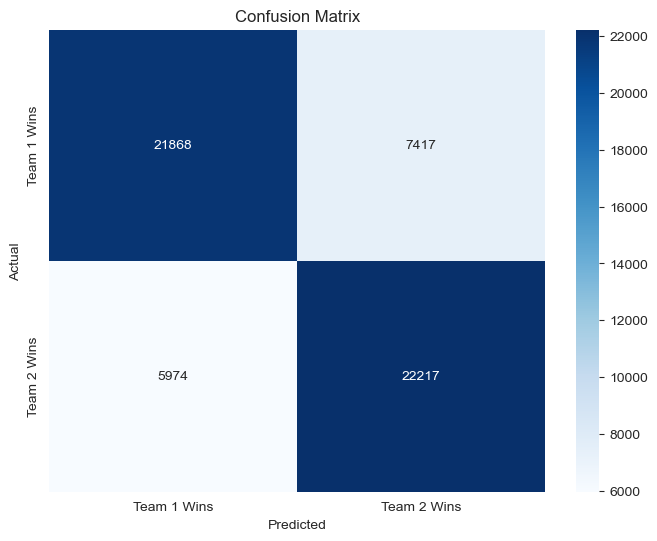

In [44]:
import seaborn as sns
from sklearn.metrics import roc_auc_score

#rf_model2 = RandomForestClassifier(n_estimators=150)
rf_model2 = GradientBoostingClassifier(n_estimators=150)

rf_model2.fit(X_train, y_train)

y_pred = rf_model2.predict(X_test)
y_prob = rf_model2.predict_proba(X_test)[:, 1]  # Probability of class 1 (Team 2 winning)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print basic metrics
#print(f"\nRandom Forest Results:")
print(f"\nGradient Booster Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Team 1 Wins', 'Team 2 Wins'],
            yticklabels=['Team 1 Wins', 'Team 2 Wins'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Top 15 Important Features:
             Feature  Importance
2   Team2_RoundScore    0.538712
1   Team1_RoundScore    0.439094
3        team1_astra    0.001708
35       team2_viper    0.001220
5    team1_brimstone    0.001202
19        team1_yoru    0.001169
8         team1_jett    0.001099
26        team2_kayo    0.000930
24      team2_cypher    0.000911
21      team2_breach    0.000874
12     team1_phoenix    0.000854
41         Map_Haven    0.000834
43         Map_Split    0.000827
22   team2_brimstone    0.000745
17        team1_sova    0.000715


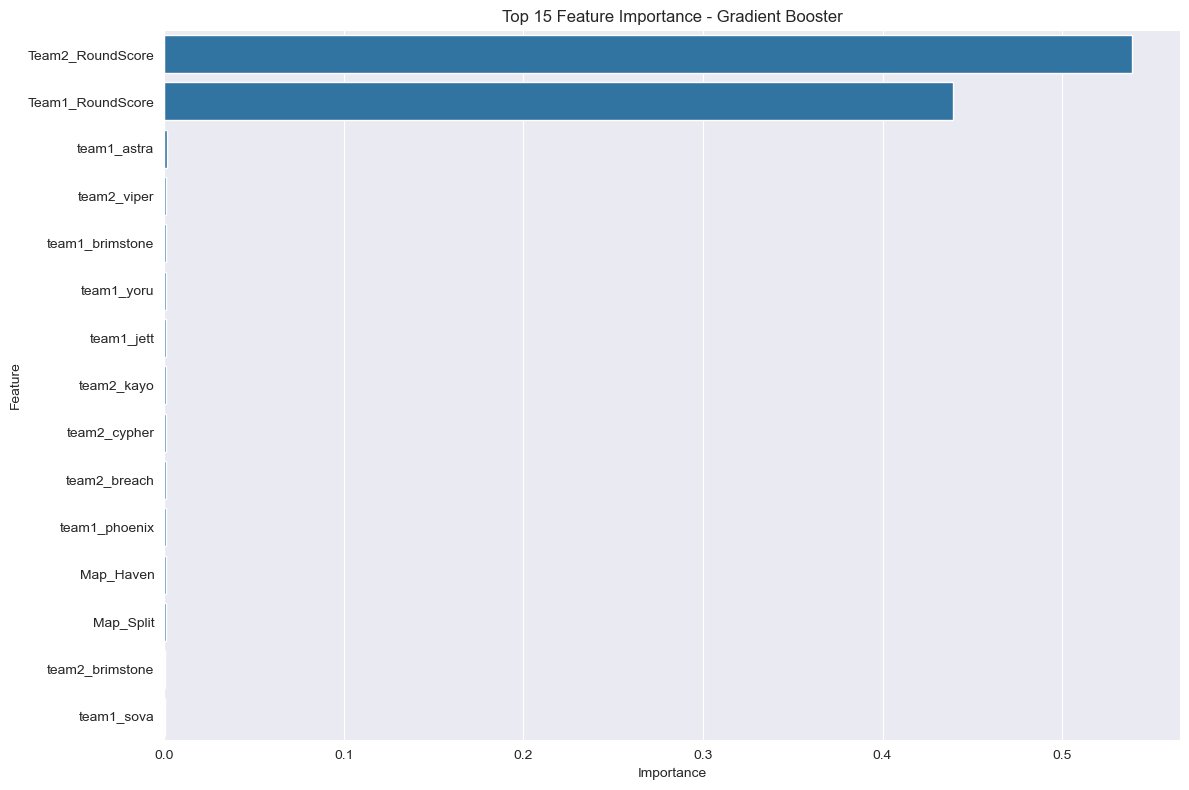

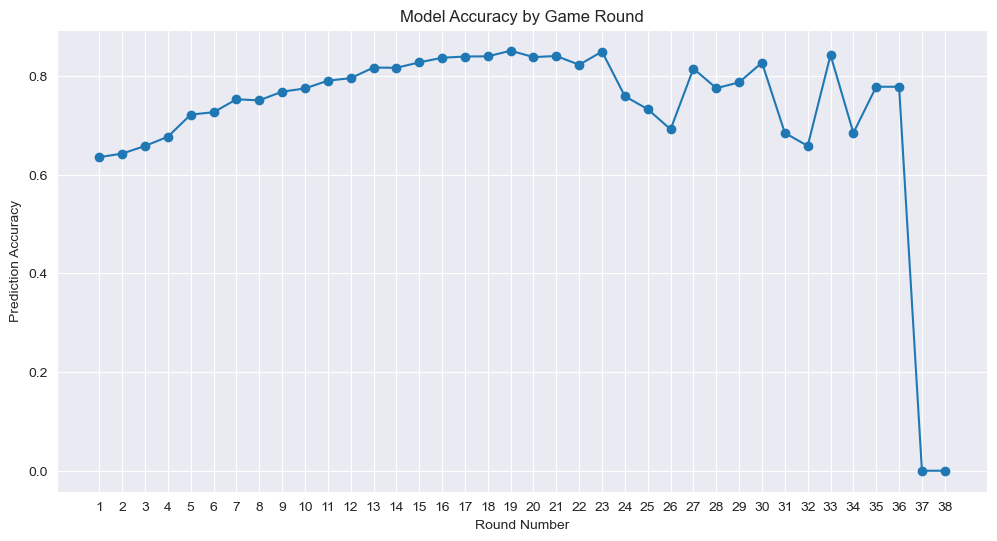


Accuracy by round:
Round 1: 0.6352
Round 2: 0.6423
Round 3: 0.6578
Round 4: 0.6765
Round 5: 0.7214
Round 6: 0.7261
Round 7: 0.7523
Round 8: 0.7502
Round 9: 0.7678
Round 10: 0.7743
Round 11: 0.7901
Round 12: 0.7951
Round 13: 0.8167
Round 14: 0.8161
Round 15: 0.8271
Round 16: 0.8365
Round 17: 0.8389
Round 18: 0.8394
Round 19: 0.8507
Round 20: 0.8378
Round 21: 0.8400
Round 22: 0.8222
Round 23: 0.8491
Round 24: 0.7585
Round 25: 0.7323
Round 26: 0.6914
Round 27: 0.8146
Round 28: 0.7748
Round 29: 0.7867
Round 30: 0.8267
Round 31: 0.6842
Round 32: 0.6579
Round 33: 0.8421
Round 34: 0.6842
Round 35: 0.7778
Round 36: 0.7778
Round 37: 0.0000
Round 38: 0.0000


In [50]:
# Extract and visualize feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model2.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top features
print("\nTop 15 Important Features:")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance - Gradient Booster')
plt.tight_layout()
plt.show()

# Round-by-round prediction accuracy (if applicable)
if 'RoundNumber' in X_test.columns:
    accuracy_by_round = {}
    for round_num in sorted(X_test['RoundNumber'].unique()):
        round_mask = X_test['RoundNumber'] == round_num
        if np.sum(round_mask) > 0:  # Only if we have samples for this round
            round_acc = accuracy_score(
                y_test[round_mask],
                y_pred[round_mask]
            )
            accuracy_by_round[round_num] = round_acc

    plt.figure(figsize=(12, 6))
    rounds = list(accuracy_by_round.keys())
    accuracies = list(accuracy_by_round.values())
    plt.plot(rounds, accuracies, marker='o')
    plt.xlabel('Round Number')
    plt.ylabel('Prediction Accuracy')
    plt.title('Model Accuracy by Game Round')
    plt.xticks(rounds)
    plt.grid(True)
    plt.show()

    print("\nAccuracy by round:")
    for round_num, acc in accuracy_by_round.items():
        print(f"Round {round_num}: {acc:.4f}")


Testing prediction

In [46]:
# User inputs for prediction
team1_agents = {"brimstone", "phoenix", "cypher", "jett", "sage"}
team2_agents = {"killjoy", "omen", "sova", "jett", "raze"}
map_to_predict = "Ascent"
current_round_scores = {"Team1_RoundScore": 1, "Team2_RoundScore": 6}

# One-hot encode agents for both teams
team1_encoded = {f'team1_{agent}': int(agent in team1_agents) for agent in all_agents}
team2_encoded = {f'team2_{agent}': int(agent in team2_agents) for agent in all_agents}
map_encoded = {f"{map}": (1 if map == "Map_" + map_to_predict else 0) for map in all_maps}

# Combine all features into a single row
input_features = {
    "RoundNumber": current_round_scores['Team1_RoundScore'] + current_round_scores['Team2_RoundScore'],  # Current round number for prediction
    **current_round_scores,
    **team1_encoded,
    **team2_encoded,
    **map_encoded
}
input_row = pd.DataFrame([input_features])

# Make the prediction
rf_probability = rf_model2.predict_proba(input_row)[0][1] * 100  # Chance of Team1 winning
rf_probability_team2 = 100 - rf_probability

# Display the results
print(f"Map: {map_to_predict}")
print(f"Team1 Composition: {team1_agents}")
print(f"Team2 Composition: {team2_agents}")
print(f"Current Score - Team1: {current_round_scores['Team1_RoundScore']}, "
      f"Team2: {current_round_scores['Team2_RoundScore']}")
print(f"Chance of Team1 winning: {rf_probability:.2f}%")
print(f"Chance of Team2 winning: {rf_probability_team2:.2f}%")

Map: Ascent
Team1 Composition: {'sage', 'brimstone', 'jett', 'phoenix', 'cypher'}
Team2 Composition: {'jett', 'sova', 'omen', 'killjoy', 'raze'}
Current Score - Team1: 1, Team2: 6
Chance of Team1 winning: 9.57%
Chance of Team2 winning: 90.43%


__Run all the previous cells in order, then the following one to save the model for use.__<br>
__Then, you can run "Valorant_Win_Prediction_UI.py"__

In [47]:
import pickle

with open('gradient_boosting_model2.pkl', 'wb') as f:
    pickle.dump(rf_model2, f)

print("Model has been saved to 'gradient_boosting_model2.pkl'")

Model has been saved to 'gradient_boosting_model2.pkl'
